# Heuristic reward with PPO and DQN agent

Exception ignored in: <function Menu.__del__ at 0x7f7e714ff1f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Potato zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x7f7e714ff1f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x7f7e714ff1f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Mushroom perilla seed soup'
Exception ignored in: <function Menu.__del__ at 0x7f7e714ff1f0>
Traceback (most recent call last):
  File "/usr/local/anaconda3/envs/rlclass/lib/python3.9/site-package

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 5
Chosen Meal: Seasoned salad with cucumber in soy red chilli paste
Chosen Meal Category: Salad
Meal History: ['S sesame sweet potato porridge' 'S sesame sweet potato porridge'
 'S sesame sweet potato porridge' 'S sesame sweet potato porridge'
 'Seasoned salad with cucumber in soy red chilli paste']
Category History: ['Soup (snack)' 'Soup (snack)' 'Soup (snack)' 'Soup (snack)' 'Salad']
Reward: 0.9364812551623203
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 5.35     |
|    exploration_rate | 0.81     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1764     |
|    time_elapsed     | 0        |
|    total_timesteps  | 20       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5        |
|    ep_rew_mean      | 5.31     |
|

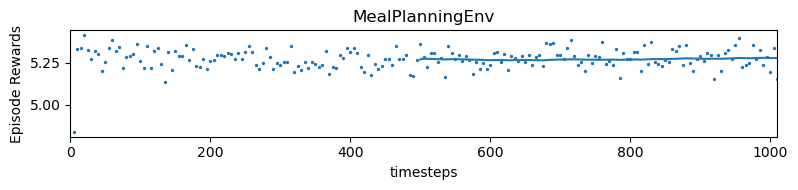

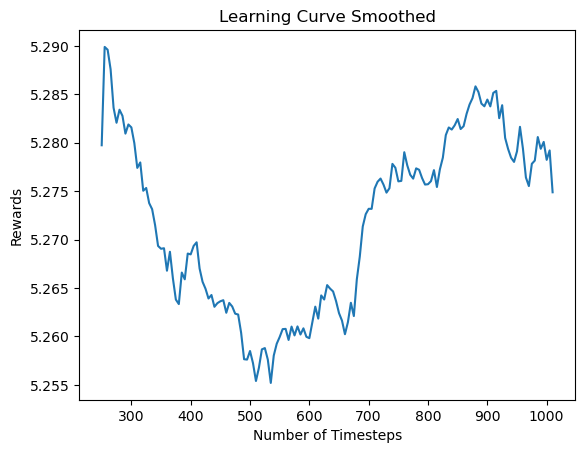

In [42]:
from stable_baselines3 import PPO, DQN
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from stable_baselines.common.evaluation import evaluate_policy


class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True


def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x, y = ts2xy(load_results(log_folder), "timesteps")
    y = moving_average(y, window=50)
    # Truncate x
    x = x[len(x) - len(y) :]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.title(title + " Smoothed")
    plt.show()
    

log_dir = f"./tmp/gym/{time.strftime('%Y%m%d-%H%M%S')}"
os.makedirs(log_dir, exist_ok=True)

all_ingredients = load_ingredient(sample_language='eng')
meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
example_mealplans = load_diet(
    menus=meal_dict, 
    num_loads=100, 
    sample_language='eng', 
    sample_name='ML'
)

# downsample meals to size num_possible_meals
num_possible_meals = len(meal_dict.keys())
old_meal_dict = meal_dict
keys_to_keep = np.random.choice(list(meal_dict.keys()), size=num_possible_meals, replace=False)
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = old_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

num_meals = 5
env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = DQN("MultiInputPolicy", env, verbose=1)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()

model = model.learn(total_timesteps=1000, callback=callback)

obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()

results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "MealPlanningEnv"
)

plot_results(log_dir)

In [4]:
obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()
num_unique_meals_chosen = len(np.unique(env.meal_history))
print(f'Possible meals: {env.possible_meals}')
print(f'Unique meals chosen: {num_unique_meals_chosen}')

Step: 5
Chosen Meal: Stir-fried bracken with perilla seeds
Chosen Meal Category: Salad
Meal History: ['Sweet potato mattang with black sesame'
 'Stir-fried bracken with perilla seeds'
 'Stir-fried bracken with perilla seeds'
 'Pork bulgogi with enoki mushrooms'
 'Stir-fried bracken with perilla seeds']
Category History: ['Deep fried' 'Salad' 'Salad' 'Stir-fried' 'Salad']
Reward: 0.274396559740045
Possible meals: ['Stir-fried bellflower root' 'Curried rice with tofu'
 'S dumpling in lemon sauce' ... 'Bean sprout beef stew'
 'Dumpling in fruit sauce' 'Steamed sweet pumpkin with nuts']
Unique meals chosen: 3


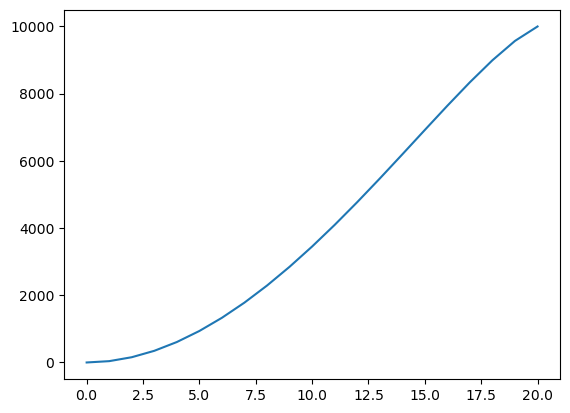

In [5]:
from collections import Counter
from scipy import stats

def entropy_of_sequence(input_list):
    # get counts
    count_data = list(Counter(input_list).values())
    
    # get entropy from counts
    entropy = stats.entropy(count_data)  
    
    return entropy

sequence = np.ones(shape=num_meals)
reward_list = []
max_entropy = entropy_of_sequence(list(range(num_meals)))
for num_unique in range(num_meals):
    sequence_to_test = list(range(num_unique)) + [-1] * (num_meals - num_unique)
    entropy_fraction = entropy_of_sequence(sequence_to_test) / max_entropy
    reward = (100 * entropy_fraction)**2
    reward_list.append(reward)
plt.plot(reward_list)

In [14]:
from stable_baselines3 import PPO, DQN
import numpy as np
import pandas as pd
from heuristic_environment import MealPlanningEnv
from dietkit import load_ingredient, load_menu, load_diet
import matplotlib.pyplot as plt

import os 
import time
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter

all_ingredients = load_ingredient(sample_language='eng')
original_meal_dict = load_menu(
    ingredients=all_ingredients,
    sample_language='eng'
)
# example_mealplans = load_diet(
#     menus=meal_dict, 
#     num_loads=100, 
#     sample_language='eng', 
#     sample_name='ML'
# )

# downsample meals to size num_possible_meals
num_possible_meals = len(original_meal_dict.keys())
keys_to_keep = np.random.choice(list(original_meal_dict.keys()), size=num_possible_meals, replace=False)
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = original_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env.reset()
for action in range(21):
    env.step(action)
env.render()

Step: 21
Chosen Meal: Little neck clam soup(clear)
Chosen Meal Category: Soup
Meal History: ['S kimchi cheese porridge' 'Pan-fried tofu with eggs'
 'Stir-fried baby anchovy' 'Seasoned crown daisy'
 'Seasoned salad with oyster mushroom and salted seaweed'
 'Dried pollack zucchini soup' 'Assorted fried fish paste soy paste soup'
 'Udon (white wheat noodles) with stir-fried teriyaki chicken'
 'Oyster tofu soup' 'Stir-fried tomato and eggs' 'S red bean porridge'
 'Fish cutlet' 'Stir-fried pork and rice in oyster sauce'
 'Steamed millet rice' 'Potato soy paste stew'
 'S black sesame soy milk (150ml)' 'Beef brisket winter cabbage soup'
 'Stir-fried dried shrimp and cabbage' 'S peach (white) - 60g'
 'Seaweed fulvescens tofu soup' 'Little neck clam soup(clear)']
Category History: ['Soup (snack)' 'Pancake' 'Stir-fried' 'Salad' 'Salad' 'Soup' 'Soup'
 'Stir-fried' 'Soup' 'Stir-fried' 'Soup (snack)' 'Deep fried'
 'Combo meal rice' 'Rice' 'Soup' 'Drink (snack)' 'Soup' 'Stir-fried'
 'Fruits (snack)'

In [11]:
nutrition_data.columns

Index(['Energy', 'Protein', 'Fat', 'Carbohydrate', 'Total Dietary', 'Calcium',
       'Iron', 'Sodium', 'Vitamin A', 'Vitamin B1 (Thiamine)',
       'Vitamin B2 (Rivoflavin)', 'Vitamin C', 'Linoleic Acid',
       'Alpha-Linolenic Acid'],
      dtype='object')

Using cpu device
Wrapping the env in a DummyVecEnv.
Step: 9
Chosen Meal: Spicy marinated duck
Chosen Meal Category: Stir-fried
Meal History: ['Clam and chive soup' 'Spicy marinated duck'
 'Deep-fried chicken in curry' 'Braised pork in soy sauce'
 'Lettuce and carrot and cucumber-wraps'
 'Stir-fried saesongyi mushroom and spinach' 'Braised fig and peanut'
 'Clam and seaweed soup' 'Spicy marinated duck']
Category History: ['Soup' 'Stir-fried' 'Deep fried' 'Braised' 'Salad' 'Stir-fried' 'Braised'
 'Soup' 'Stir-fried']
Current Nutrition % of Goal: [    70    400    280    120    120     90    370    790    170    270
    370    110 233630 151850]
Reward: [853.50961411   0.           0.           0.           0.
   0.        ] --> 853.5096141123793
Num timesteps: 1000
Best mean reward: -inf - Last mean reward per episode: 4743.09
Saving new best model to ./tmp/gym/20230423-113812/best_model.zip
Num timesteps: 2000
Best mean reward: 4743.09 - Last mean reward per episode: 4803.24
Saving new 

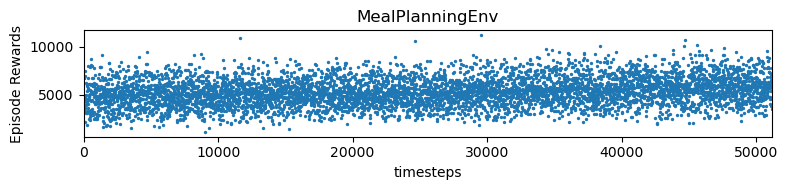

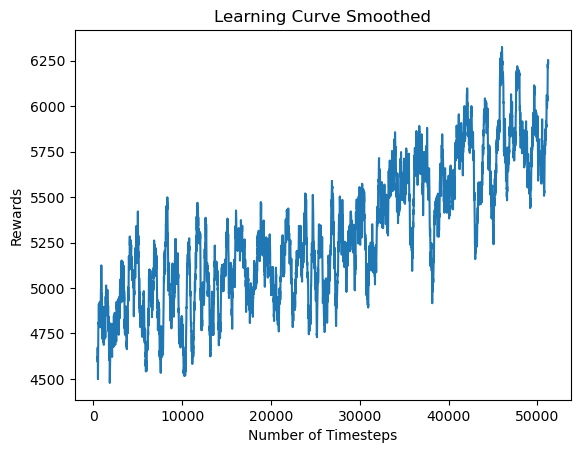

In [109]:
from itertools import groupby
from collections import Counter

import gym
import numpy as np
from scipy import stats


def entropy_of_sequence(input_list):
    # get counts
    count_data = list(Counter(input_list).values())
    
    # get entropy from counts
    entropy = stats.entropy(count_data)  
    
    return entropy


class MealPlanningEnv(gym.Env):
    metadata = {'render.modes': ['human', 'json']}

    def __init__(self, possible_meals, meal_categories, nutrition_data, num_meals):
        super(MealPlanningEnv, self).__init__()

        self.possible_meals = possible_meals
        self.meal_categories = meal_categories
        # add 'empty' meal category if not there
        if 'empty' not in self.meal_categories:
            self.meal_categories = np.append(self.meal_categories, ['empty'])
            
        self.num_possible_meals = len(self.possible_meals)
        self.unique_meal_categories = np.unique(self.meal_categories)
        self.num_meal_categories = len(self.unique_meal_categories)
        self.nutrition_data = nutrition_data
        self.num_meals = num_meals
        self.current_step = None
        self.action_space = gym.spaces.Discrete(self.num_possible_meals)
        
        self.nutrition_history_shape = (self.num_meals, len(self.nutrition_data.columns))
        self.observation_space = gym.spaces.Dict({
            'meal_history': gym.spaces.Box(
                low=0,
                high=self.num_possible_meals,
                shape=(self.num_meals,),
                dtype=np.int64
            ),
            'nutrition_history': gym.spaces.Box(
                low=0,
                high=np.inf,
                shape=self.nutrition_history_shape,
                dtype=np.float32
            ),
            'category_history': gym.spaces.Box(
                low=0,
                high=self.num_meal_categories,
                shape=(self.num_meals,),
                dtype=np.int64
            ),
            'lower_goal_nutrition': gym.spaces.Box(
                low=0,
                high=np.inf,
                shape=(len(nutrition_data.columns),),
                dtype=np.float32
            ),
            'upper_goal_nutrition': gym.spaces.Box(
                low=0,
                high=np.inf,
                shape=(len(nutrition_data.columns),),
                dtype=np.float32
            )
        })
    
    def _get_lowerbound_goal_nutrition(self):
        # this is the dietkit guideline for a sequence of 19 meals:
        # energy in [1260, 1540]
        # protein >= 20
        # fat in [15, 30]
        # carbs in [55, 65]
        # total dietary in [11, 20]
        # calcium in [500, 2500]
        # iron in [5, 40]
        # sodium < 1600
        # vitamin a in [230, 750]
        # vitamin b1 thiamine > 0.4
        # vitamine b2 riboflavine > 0.5
        # vitamin c in [35, 510]
        # linoleic acid in [4.6, 9.1]
        # alpha-linolenic acid in [0.6, 1.17]
        
        # set goal at min of each range
        goal_nutrition_lowerbound = np.array([
            1260, 
            20,
            15,
            55,
            11,
            500,
            5,
            1600 / 5,
            230,
            0.4,
            0.5,
            35,
            4.6,
            0.6
        ])
        
        return goal_nutrition_lowerbound * self.num_meals / 19
    
    def _get_upperbound_goal_nutrition(self):
        goal_nutrition_upperbound = np.array([
            1540, 
            20 * 5,
            30,
            65,
            20,
            2500,
            40,
            1600,
            750,
            0.4 * 10,
            0.5 * 10,
            510,
            9.1,
            1.17
        ])
        
        return goal_nutrition_upperbound * self.num_meals / 19
        
    
    def _calculate_current_nutrition(self):
        return self.nutrition_history[0:self.current_step, :].sum(axis=0)

    def reset(self):
        self.current_step = 0
        # set all meals to the 'empty' meal
        self.meal_history = np.zeros(self.num_meals) + self.num_possible_meals - 1
        self.nutrition_history = np.zeros(self.nutrition_history_shape)
        # set all categories to the 'empty' category
        self.category_history = np.zeros(self.num_meals)
        self.lower_goal_nutrition = self._get_lowerbound_goal_nutrition()
        self.upper_goal_nutrition = self._get_upperbound_goal_nutrition()
        return self._next_observation()

    def step(self, action):
        chosen_meal = self.possible_meals[action]
        chosen_meal_category = self.meal_categories[action]
        nutrition = self.nutrition_data.loc[chosen_meal].values
        
        self.meal_history[self.current_step] = action
        self.nutrition_history[self.current_step, :] = nutrition
        self.category_history[self.current_step] = self.unique_meal_categories.tolist().index(chosen_meal_category)

        done = self.current_step == self.num_meals - 1
        info = {}

        self.current_step += 1

        reward_array = self._calculate_reward()
        reward = reward_array.sum()

        return self._next_observation(), reward, done, info

    def render(self, mode='human', close=False):
        if mode == 'human':
            print(f'Step: {self.current_step}')
            print(f'Chosen Meal: {self.possible_meals[self.meal_history[self.current_step - 1].astype(int)]}')
            print(f'Chosen Meal Category: {self.meal_categories[self.meal_history[self.current_step - 1].astype(int)]}')
            print(f'Meal History: {self.possible_meals[self.meal_history.astype(int)]}')
            print(f'Category History: {self.unique_meal_categories[self.category_history.astype(int)]}')
            print(f'Current Nutrition % of Goal: {(np.divide(self._calculate_current_nutrition(), self.lower_goal_nutrition).round(1) * 100).astype(int)}')
            print(f'Reward: {self._calculate_reward()} --> {self._calculate_reward().sum()}')
        else:
            pass

    def _next_observation(self):
        obs = {
            'meal_history': self.meal_history,
            'nutrition_history': self.nutrition_history,
            'category_history': self.category_history,
            'lower_goal_nutrition': self.lower_goal_nutrition,
            'upper_goal_nutrition': self.upper_goal_nutrition
        }
        return obs

    def _calculate_reward(self):
        # take current percentage of nutrition met, treating each category equally, on [0, 1] scale
        
        # reaches 1 when at minimum nutrition
        # otherwise mean fraction of current nutrition requirement
        current_nutrition = self._calculate_current_nutrition()
        lower_nutrition_fractions = np.divide(current_nutrition, self.lower_goal_nutrition)
        lower_nutrition_fractions = np.array([min(fraction, 1) for fraction in lower_nutrition_fractions])
        lower_nutrition_score = lower_nutrition_fractions.mean()
        
        # reaches 1 when all categories above maximum nutrition
        # otherwise fraction of categories that are above maximum
        upper_nutrition_fractions = np.divide(current_nutrition, self.upper_goal_nutrition)
        upper_nutrition_fractions = np.array([fraction > 1 for fraction in upper_nutrition_fractions])
        upper_nutrition_penalty = upper_nutrition_fractions.mean()
        
        
        # calculate 3 measures of current compositional diversity, all on [0, 1] scale
        # 1. if there are meals repetitions in a sequence of length unique_sequence_length, penalize
        unique_sequence_length = 3
        max_entropy_per_sequence = entropy_of_sequence(range(unique_sequence_length))
        entropy_fractions = []
        for start_index in range(self.num_meals - unique_sequence_length + 1):
            end_index = start_index + unique_sequence_length
            sequence_to_check = self.meal_history[start_index:end_index]
            entropy_fraction = entropy_of_sequence(sequence_to_check) / max_entropy_per_sequence
            entropy_fractions.append(entropy_fraction)
        mean_sequence_entropy_fraction = np.mean(entropy_fractions)
        
        # 2. If there are more than num_allowed_in_a_row, penalize even more
        # count repetitions of each element in order
        # reaches 1 when everything is repeated (so to speak)
        # otherwise fraction of total possible # repetitions
        sequential_counts = [(meal, len(list(appearances))) for meal, appearances in groupby(self.meal_history)]
        max_num_allowed_in_a_row = 1
        total_num_repetitions = np.sum([appearances > max_num_allowed_in_a_row for _, appearances in sequential_counts])
        reptition_penalty = total_num_repetitions / self.num_meals
        
        # 3. Check entropy of meals overall as fraction of max possible, on [0, 1] scale
        overall_entropy = entropy_of_sequence(self.meal_history)
        max_overall_entropy = entropy_of_sequence(list(range(self.num_meals)))
        overall_entropy_fraction = 1 - overall_entropy / max_overall_entropy
        
        # overall reward linear combo of nutrition and composition
        coef_nutrition_lower = 0
        coef_nutrition_upper = 0
        coef_sequence_entropy = 0
        coef_repetitions = 0
        coef_overall_entropy = 0
        reward_array = np.array([
            current_nutrition.sum(),
            coef_nutrition_lower * lower_nutrition_score,
            coef_nutrition_upper * upper_nutrition_penalty,
            coef_sequence_entropy * mean_sequence_entropy_fraction,
            coef_repetitions * reptition_penalty, 
            coef_overall_entropy * overall_entropy_fraction
        ]) / self.num_meals
        
        return reward_array


# downsample meals to size num_possible_meals
# num_possible_meals = len(original_meal_dict.keys())
num_possible_meals = 100
keys_to_keep = np.random.choice(list(original_meal_dict.keys())[:-1], size=num_possible_meals - 1, replace=False).tolist() + ['empty']
meal_dict = {}
for key in keys_to_keep:
    meal_dict[key] = original_meal_dict[key]

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

num_meals = 9
env = MealPlanningEnv(
  possible_meals=possible_meals, 
  meal_categories=meal_categories,
  nutrition_data=nutrition_data, 
  num_meals=num_meals
)

env = Monitor(env, log_dir)
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)

model = PPO("MultiInputPolicy", env, verbose=2)
obs = env.reset()
for i in range(num_meals):
  action, _ = model.predict(obs)
  obs, rewards, done, info = env.step(action)
env.render()

model.learn(total_timesteps=50000, callback=callback)

obs = env.reset()
action, _ = model.predict(obs)
for _ in range(num_meals):
  obs, rewards, done, info = env.step(action)
  action, _ = model.predict(obs)
env.render()

results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "MealPlanningEnv"
)

plot_results(log_dir)

# model.save(log_dir + '' + f'-num_meals={num_meals}' + f'-model={dqn}' + f'-steps={total_timesteps}')

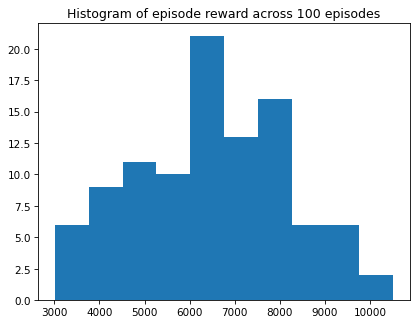

In [102]:
n_eval_episodes = 100
reward_means, reward_stds = evaluate_policy(model=model, env=env, n_eval_episodes=n_eval_episodes, render=False, return_episode_rewards=True, deterministic=False)
plt.figure(dpi=75)
plt.hist(reward_means)
plt.title(f'Histogram of episode reward across {n_eval_episodes} episodes')
plt.show()

The spread of this distribution shows that reward can vary after training. 

In [106]:
episode_reward = 0
while episode_reward < np.quantile(reward_means, 0.75):
  obs = env.reset()
  done, state = False, None
  episode_reward = 0
  while not done:
    action, state = model.predict(obs, state=state, deterministic=False)
    obs, reward, done, info = env.step(action)
    episode_reward += reward
env.render()
print(f'Epsiode reward: {episode_reward}')

Step: 9
Chosen Meal: Sakhalin surf-clam and seaweed soup
Chosen Meal Category: Soup
Meal History: ['Seasoned salad with hijiki' 'Seasoned dried radish leaves'
 'Stir-fried glass noodles' 'S chilled bean soup with noodles'
 'Deep-fried aubergine in spicy sauce'
 'Stir-fried rice with eggs and spring onion'
 'Braised pollack in marinade sauce'
 'Braised tofu and rice cake in soy sauce'
 'Sakhalin surf-clam and seaweed soup']
Category History: ['Salad' 'Salad' 'Stir-fried' 'Combo meal (snack)' 'Deep fried'
 'Combo meal rice' 'Braised' 'Braised' 'Soup']
Reward: [1664.72189411    0.            0.            0.            0.
    0.        ] --> 1664.721894113542
Epsiode reward: 8111.135008386036


This is one example run that achieves high reward in non-deterministic mode.

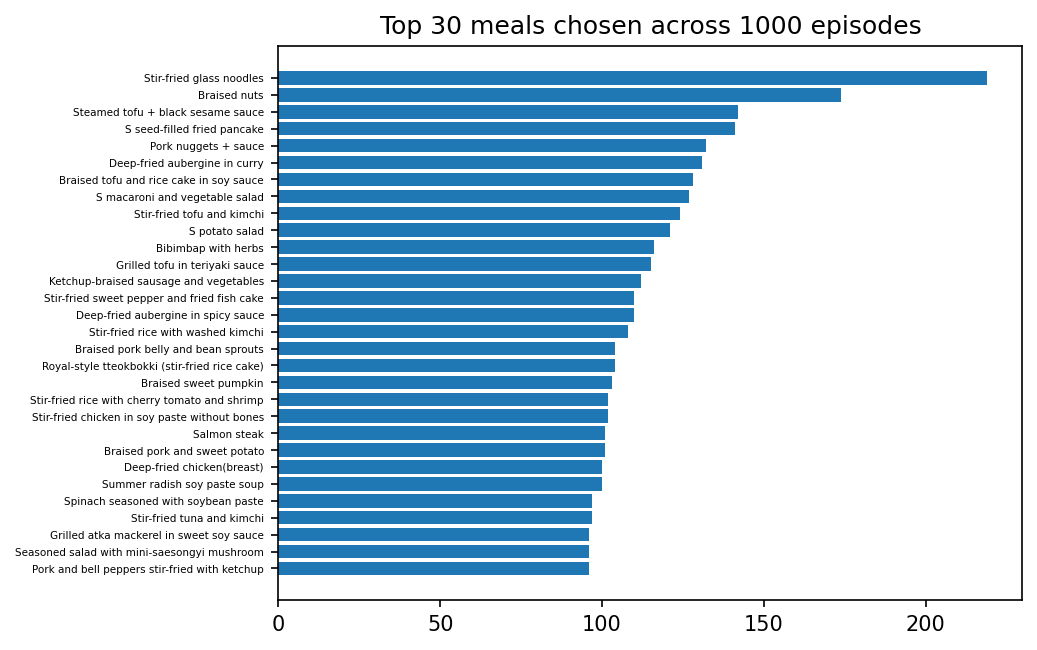

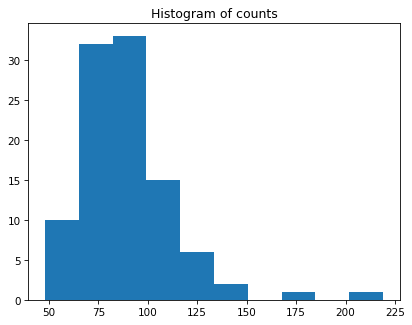

In [104]:
num_episodes = 1000
num_meals_to_show = 30
episode_rewards = []
meal_counter = Counter()
for _ in range(num_episodes):
    obs = env.reset()
    done, state = False, None
    episode_reward = 0
    while not done:
        action, state = model.predict(obs, state=state, deterministic=False)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
    episode_rewards.append(episode_reward)
    chosen_meals = env.possible_meals[env.meal_history.astype(int)]
    meal_counter.update(chosen_meals)

meals_chosen, counts = list(zip(*sorted(meal_counter.items(), key=lambda x: x[1], reverse=False)))
selected_meals = meals_chosen[-num_meals_to_show:]
selected_counts = counts[-num_meals_to_show:]
y_pos = np.arange(len(selected_meals))
plt.figure(dpi=150)
plt.barh(y=y_pos, width=selected_counts)
plt.yticks(y_pos, selected_meals, size=5)
plt.title(f'Top {num_meals_to_show} meals chosen across {num_episodes} episodes')
plt.show()

plt.figure(dpi=75)
plt.hist(counts)
plt.title('Histogram of counts')
plt.show()

If there are lots of small counts, that shows that there's lots of variety in the chosen meals.
If there are fewer counts that are larger, that shows that there are particular meals that are favored to maximize reward.